# CNN_MNIST_PROJECT


In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset


### Loading and preprocessing the data

In [2]:
# MNIST dataset
image_path = './'
transforms = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transforms, 
                                           download=True)


12.6%

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100.0%
100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
# Splitting the dataset into train, validation, and test sets
mnist_valid_dataset = Subset(mnist_dataset,
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,
                             torch.arange(10000,
                                          len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                                train=False, transform=transforms, download=False)


In [4]:
# Creating the dataloaders 
batch_size = 64
train_dl = DataLoader(mnist_train_dataset, 
                      batch_size=batch_size, 
                      shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, 
                      batch_size=batch_size,
                      shuffle=False)


### Constacting CNN

In [5]:
# Model
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1,
        out_channels=32,
        kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))


In [6]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
# Device-agnostic code 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [8]:
# Train model
def train(model, num_epochs, train_dl, valid_dl):
    # Initialize empty lists to store loss and accuracy history
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    # Loop through each epoch
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        # Loop through each batch in the training data
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            # Forward pass and compute loss
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            # Backward pass, compute gradients and update parameters
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update training loss and accuracy history
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
        
        # Compute average training loss and accuracy for the epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            # Loop through each batch in the validation data
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                # Forward pass and compute loss
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                # Update validation loss and accuracy history
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
                
        # Compute average validation loss and accuracy for the epoch
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        # Print training and validation accuracy for the epoch
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    # Return loss and accuracy history for both training and validation data
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 accuracy: 0.9547 val_accuracy: 0.9822
Epoch 2 accuracy: 0.9858 val_accuracy: 0.9875
Epoch 3 accuracy: 0.9900 val_accuracy: 0.9887
Epoch 4 accuracy: 0.9917 val_accuracy: 0.9867
Epoch 5 accuracy: 0.9937 val_accuracy: 0.9887
Epoch 6 accuracy: 0.9955 val_accuracy: 0.9906
Epoch 7 accuracy: 0.9952 val_accuracy: 0.9910
Epoch 8 accuracy: 0.9958 val_accuracy: 0.9879
Epoch 9 accuracy: 0.9967 val_accuracy: 0.9892
Epoch 10 accuracy: 0.9970 val_accuracy: 0.9908


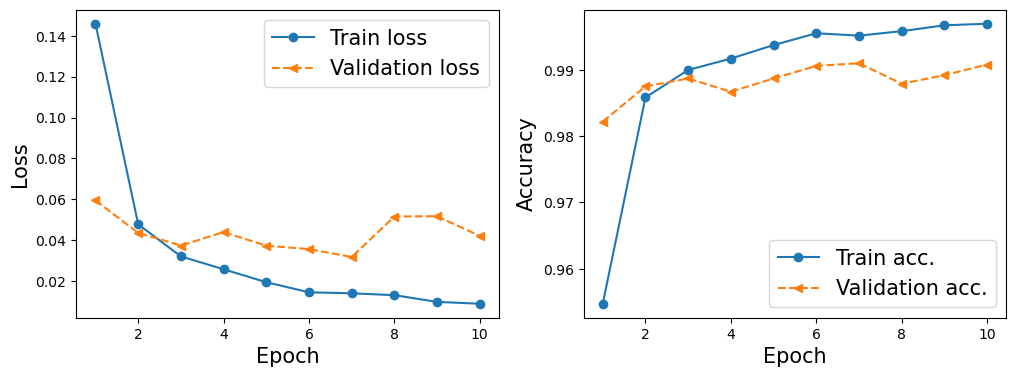

In [9]:
# Visualizing the CNN model performance
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)


plt.show()

In [10]:
# Prediction the model on the test dataset
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9918


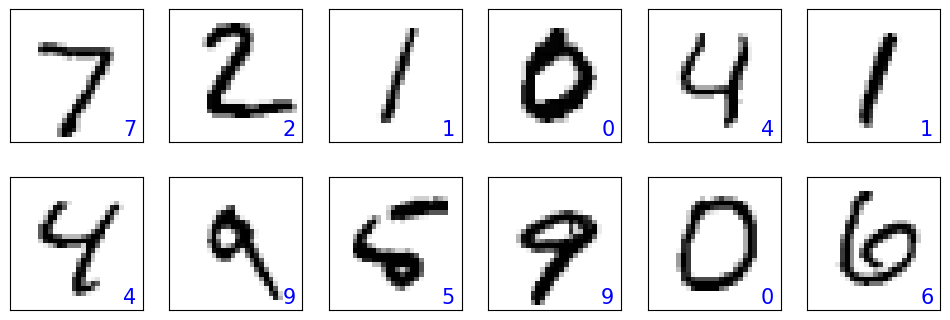

In [11]:
# Visualizing predicted labels 
fig = plt.figure(figsize=(12, 4)) 
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()
